# Pretraining with stacked autoencoders
Assignment 2 **Task 2** | Notebook by **Group 19**

In this notebook we will first train three encoder-decoder networks separately to generate reduced dimension representations of the data at hand. After that, we chain the encoders of these AANNs to generate an autoencoder, which we will fix prior to a classification layer.

In [1]:
# Dependencies
import os
import numpy as np
import pandas as pd 
from glob import glob
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib notebook

## Data Loaders
In this section, we define functions to load all images and labels into lists from disk, and to generate dataloaders compatible with PyTorch models. 

In [2]:
# Function to load files and generate torch data loaders

def get_data(root_path, ext='jpg_color_edh_entropy'):
    
    main_data, labels = [], []
    
    for f in os.listdir(root_path):
        paths = glob(root_path + '/' + f + '/*.' + ext)
        for path in tqdm(paths):
            vals = pd.read_csv(path, sep=' ', header=None).values
            main_data.append(vals.flatten())
            labels.append(f)

    main_data, labels = np.asarray(main_data), np.asarray(labels)

    # Label encode target
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    return main_data, labels


def get_data_loaders(features, target, test_split=0.2):
    
    if test_split is not None:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split, shuffle=True)
        X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
        y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

        d_train = torch.utils.data.TensorDataset(X_train, y_train)
        d_test = torch.utils.data.TensorDataset(X_test, y_test)

        train_loader = torch.utils.data.DataLoader(d_train, batch_size=64, shuffle=True)
        test_loader = torch.utils.data.DataLoader(d_test, batch_size=64, shuffle=True)
        
        return train_loader, test_loader
    
    else:
        X, y = torch.from_numpy(features), torch.from_numpy(target)
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        
        return loader
    
    
# Get all data
all_data, labels = get_data('../data/data1')

100%|██████████| 410/410 [00:00<00:00, 465.55it/s]


## Runtime functions
Here we define functions for training and evaluation of the model's progress. First, we define functions for classifier networks with Nonlinear Logloss (NLL Loss). Then we define functions for regression networks with Mean Squared Error (MSE) Loss. These will be used for configuring encoder-decoder models. 

In [3]:
# Training function

def train_clf(model, train_loader, optimizer, epoch):
    # Set model in training mode
    model.train()  
    # List to store loss values for each batch
    loss_history = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate predictions using model
        output = model(data.float())
        # Compute loss (Nonlinear logloss)
        loss = F.nll_loss(output, target)
        # Append value of loss to loss_history list
        loss_history.append(loss.item())
        # Backpropagate loss to improve model parameters
        loss.backward()
        # Find number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # Update optimizer parameters
        optimizer.step()
    
    accuracy = 100*correct/len(train_loader.dataset)
    
    return np.array(loss_history).mean(), accuracy
        
    
# Test function

def test_clf(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode
    # Model paramters do not change when in this state
    model.eval()
    # Counters for overall loss and correct classifications for test data
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute loss value (sum over all examples) and update test_loss 
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Find prediction index
            pred = output.argmax(dim=1, keepdim=True)
            # Transform target into one-hot vector and find number of correct classifications
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    
    # Console ouptut
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f} \t Accuracy: {}/{} ({:.2f}%)".format(
            epoch, test_loss, correct, len(test_loader.dataset), test_accuracy
        ))
        
    return test_loss, test_accuracy 

# ====================================================================================
# Train and test functions for regression networks
# These will be used to track reconstruction loss for encoder-decoder networks
# ====================================================================================

# Training function

def train_reg(model, train_loader, optimizer, epoch):
    # Set model in training mode (parameter updates valid)
    model.train()
    # List to store total loss for each batch
    loss_history = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate model predictions
        output = model(data.float())
        # Calculate MSE loss
        loss = F.mse_loss(output.float(), target.float())
        loss_history.append(loss.item())
        # Backpropagate loss
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    
    return np.array(loss_history).mean()
        
    
# Test function

def test_reg(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode (no parameter updates)
    model.eval()
    # Loss counter for test data
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute MSE loss and update test_loss
            test_loss += F.mse_loss(output.float(), target.float(), reduction='mean').item()
            
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    
    # Console output
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f}".format(
            epoch, test_loss
        ))
        
    return test_loss

## Encoder-Decoder networks
Here we will define and train three encoder-decoder networks to reconstruct the data individually. The reduction sizes of the networks are as follows.

$$
(828, 500) ==> (500, 300) ==> (300, 200)
$$


In [4]:
class EncoderDecoder_1(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_1, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(828, 500),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(500, 828),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out
    

class EncoderDecoder_2(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_2, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(500, 300),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(300, 500),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out
    
    
class EncoderDecoder_3(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_3, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(300, 200),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(200, 300),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out

## Training the AANNs
Here we train the networks one after another.

Test 0 : Average loss: 0.0059
Test 10 : Average loss: 0.0046
Test 20 : Average loss: 0.0044
Test 30 : Average loss: 0.0043
Test 40 : Average loss: 0.0043
Test 50 : Average loss: 0.0043
Test 60 : Average loss: 0.0043
Test 70 : Average loss: 0.0043
Test 80 : Average loss: 0.0043
Test 90 : Average loss: 0.0043


<IPython.core.display.Javascript object>


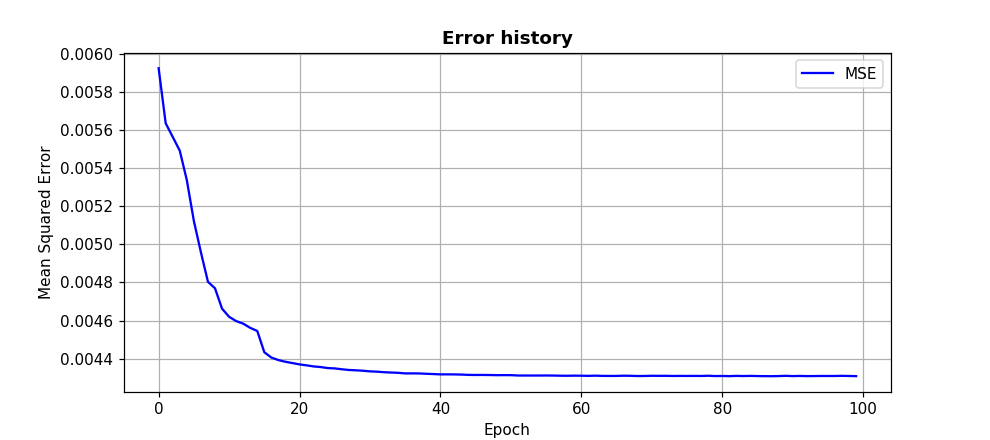

In [5]:
# Data loaders for first network
all_data_torch = torch.from_numpy(all_data)
dataset = torch.utils.data.TensorDataset(all_data_torch, all_data_torch)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


# Train first network
ed_1 = EncoderDecoder_1()
optimizer = optim.Adam(ed_1.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist = []
test_loss_hist = []

for epoch in range(100):
    train_loss = train_reg(ed_1, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_1, data_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

    
# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()
    
# Get output from encoder-1
latent_1 = ed_1.encoder(all_data_torch.float()).detach().numpy()

Test 0 : Average loss: 0.0008
Test 10 : Average loss: 0.0001
Test 20 : Average loss: 0.0001
Test 30 : Average loss: 0.0001
Test 40 : Average loss: 0.0001
Test 50 : Average loss: 0.0001
Test 60 : Average loss: 0.0001
Test 70 : Average loss: 0.0001
Test 80 : Average loss: 0.0001
Test 90 : Average loss: 0.0001


<IPython.core.display.Javascript object>


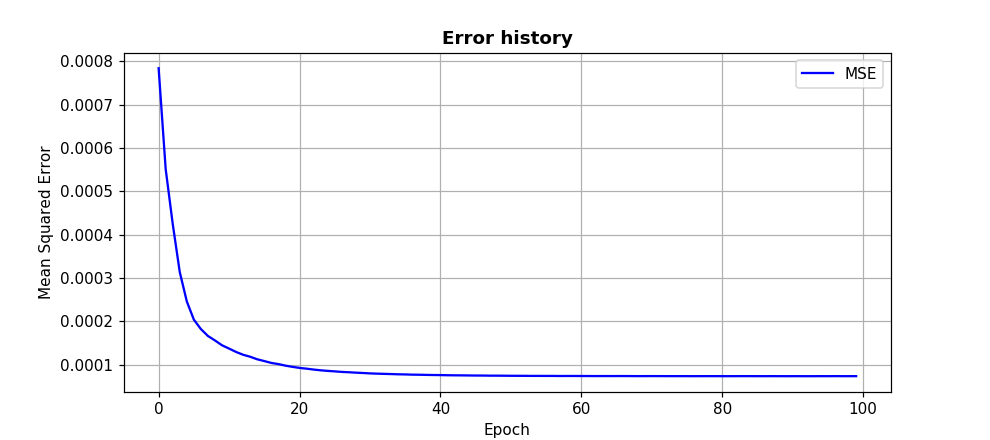

In [6]:
# Generate dataloader for latent_1
latent_1_torch = torch.from_numpy(latent_1)
latent_1_dataset = torch.utils.data.TensorDataset(latent_1_torch, latent_1_torch)
latent_1_loader = torch.utils.data.DataLoader(latent_1_dataset, batch_size=64, shuffle=True)


# Train second network
ed_2 = EncoderDecoder_2()
optimizer = optim.Adam(ed_2.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

for epoch in range(100):
    train_loss = train_reg(ed_2, latent_1_loader, optimizer, epoch)
    test_loss = test_reg(ed_2, latent_1_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
    
# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()

# Get output from encoder-2
latent_2 = ed_2.encoder(latent_1_torch.float()).detach().numpy()

Test 0 : Average loss: 0.0033
Test 10 : Average loss: 0.0012
Test 20 : Average loss: 0.0012
Test 30 : Average loss: 0.0012
Test 40 : Average loss: 0.0012
Test 50 : Average loss: 0.0012
Test 60 : Average loss: 0.0012
Test 70 : Average loss: 0.0012
Test 80 : Average loss: 0.0012
Test 90 : Average loss: 0.0012


<IPython.core.display.Javascript object>


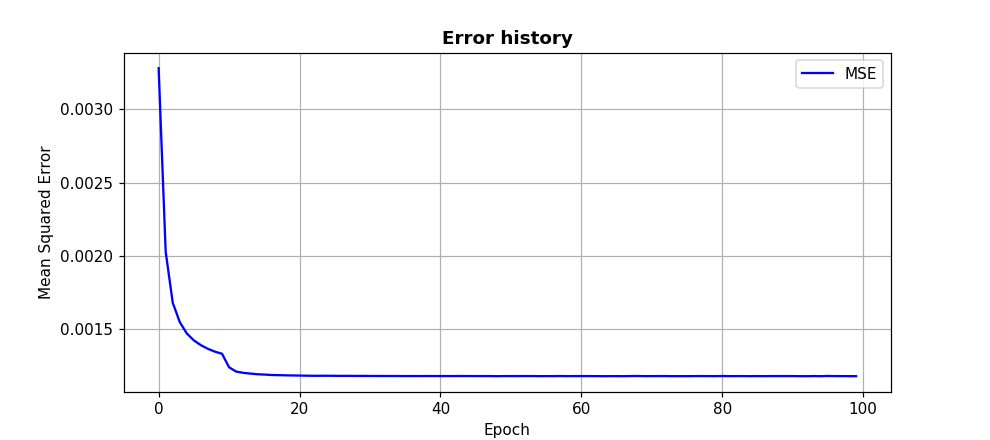

In [7]:
# Generate data loader for latent_2 
latent_2_torch = torch.from_numpy(latent_2)
latent_2_dataset = torch.utils.data.TensorDataset(latent_2_torch, latent_2_torch)
latent_2_loader = torch.utils.data.DataLoader(latent_2_dataset, batch_size=64, shuffle=True)


# Train second network
ed_3 = EncoderDecoder_3()
optimizer = optim.Adam(ed_3.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

for epoch in range(100):
    train_loss = train_reg(ed_3, latent_2_loader, optimizer, epoch)
    test_loss = test_reg(ed_3, latent_2_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()
    
# Get output from encoder-3
latent_3 = ed_3.encoder(latent_2_torch.float()).detach().numpy()

Test 0 : Average loss: 1.4942 	 Accuracy: 95/356 (26.69%)
Test 10 : Average loss: 1.1994 	 Accuracy: 177/356 (49.72%)
Test 20 : Average loss: 1.1709 	 Accuracy: 173/356 (48.60%)
Test 30 : Average loss: 1.1809 	 Accuracy: 177/356 (49.72%)
Test 40 : Average loss: 1.1936 	 Accuracy: 175/356 (49.16%)
Test 50 : Average loss: 1.1903 	 Accuracy: 174/356 (48.88%)
Test 60 : Average loss: 1.1923 	 Accuracy: 175/356 (49.16%)
Test 70 : Average loss: 1.1918 	 Accuracy: 174/356 (48.88%)
Test 80 : Average loss: 1.1919 	 Accuracy: 174/356 (48.88%)
Test 90 : Average loss: 1.1918 	 Accuracy: 174/356 (48.88%)


<IPython.core.display.Javascript object>


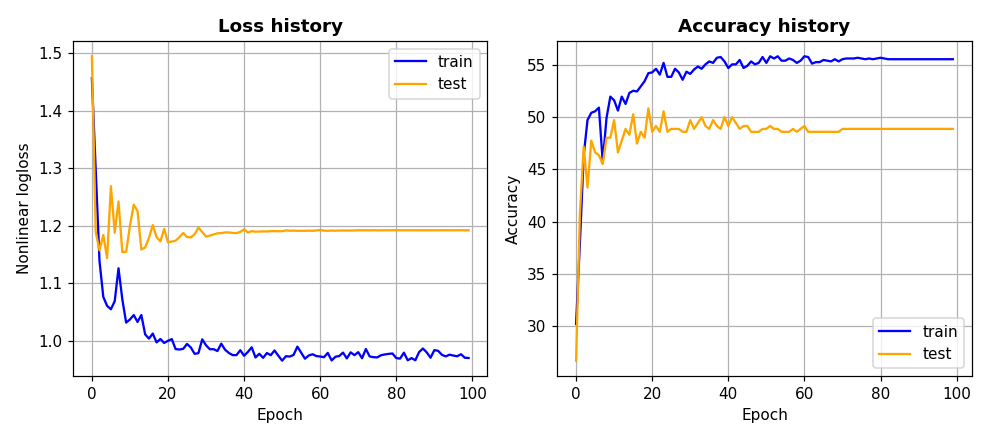

Final training loss: 0.9700
Final training accuracy: 55.5478
Final validation loss: 1.1919
Final validation accuracy: 48.8764


In [20]:
# Final network
# All encoder layers sequentially then a softmax layer

net = torch.nn.Sequential(
    ed_1.encoder,
    ed_2.encoder,
    ed_3.encoder,
    torch.nn.Linear(200, 5),
    torch.nn.LogSoftmax(dim=1)
)

# Main data loader
train_loader, test_loader = get_data_loaders(all_data, labels, test_split=0.2)

# Train
optimizer = optim.Adam(net.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(net, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(net, test_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    

# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## Conclusions 

This experiment is an extension of the last subtask of Task 1, where we stacked two encoders to generate latent representation of our data. It turns out that adding a third encoder gave a slight improvement to the accuracy, but did not bridge the gap between train and test loss (or accuracy) much. The network might still be experiencing overfitting due to the large number of parameters it has to tune.